# Scikit-Learn Estimators

## Table of Content 

- [Regression](#regression)
  - [Distance Based Regressor](#distance-based-regression)
    - [Linear Regression](#linear-regression)
    - [IRLS Robust Regression With Huber Weight Function](#irls-robust-regression-with-huber-weight-function)
    - [Random Sample Consensus](#random-sample-consensus)
  - [Tree Based Regressor](#tree-based-regression)
    - [Decision Tree Regressor](#decision-tree-regressor)
    - [Voting Regressor](#voting-regressor)
    - [Bagging Regressor](#bagging-regressor)
    - [Random Forest Regressor](#random-forest-regressor)
    - [Extra Tree Regressor](#extra-tree-regressor)
    - [AdaBoost Regressor](#adaboost-regressor)
- [Classification](#classification)
  - [Distance Based Classifier](#distance-based-classifier)
    - [Logistic Regression](#logistic-regression)
  - [Tree Based Classifier](#tree-based-classifer)
    - [Decision Tree Classifier](#decision-tree-classifier)
    - [Bagging Classifier](#bagging-classifier)
    - [Voting Classifier](#voting-classifier)
    - [Random Forest Classifier](#random-forest-classifier)
    - [Extra Tree Classifier](#extra-tree-classifier)
    - [AdaBoost Classifier](#adaboost-classifier)

# Regression

## Distance Based Regressor

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

LinearRegression(
    fit_intercept=True, normalize="deprecated", copy_X=True, n_jobs=-1, positive=False
)

### Preprocessing

* Requires standardization (subtract mean and divide by standard deviation). Based on Kutner, M. H., Nachtsheim, C., Neter, J. Applied linear statistical models.

* Multicollinearity- when predictor variables are correlated, the regression coefficient of any one variable depends on which other predictor variables are included and which ones are left out. The common interpretation of a regression coefficient as measuring the change in the expected value of the response variable when the given predictor is increased by one unit while all other predictor variables are held constant is not fully applicable.

* Sensitive to outliers, influential observations:

    * Outlying target values (studentized deleted residuals, studentized residuals)
  
    * Outlying X observations (hat matrix, leverage values)

    * Influential cases (DFFITS, Cook's Distance, DFBETAS)
  

### IRLS Robust Regression With Huber Weight Function

For robust regression, weighted least squares is used to reduce the influence of outlying cases by employing weights that vary inversely with the size of the residual. The weight function for each training sample has the following formulation based on the Applied Linear Regression Models book:

$$
w= \begin{cases}1 & |u| \leq 1.345 \\ \frac{1.345}{|u|} & |u|>1.345\end{cases}
$$

where

* $u_{i}=\frac{Y_{i} - \hat{Y_{i}}}{M A D}=\frac{e_{i}}{M A D}$
  
* $M A D=\frac{1}{.6745} \text { median }\left\{\left|e_{i}-\operatorname{median}\left\{e_{i}\right\}\right|\right\}$ and the constant $.6745$ provides an approximately unbiased estimate of $\sigma$ for independent observations from a normal distribution.

The scikit-learn formation states that the `HuberRegressor` optimizes the squared loss for the samples where `|(y - X'w) / sigma| < epsilon` and the absolute loss for the samples where `|(y - X'w) / sigma| > epsilon`, where `w` and `sigma` are parameters to be optimized.

In [ ]:
from sklearn.linear_model import HuberRegressor

HuberRegressor(
    epsilon=1.35,
    # This needs to be tweaked to get convergence
    max_iter=1000,
    alpha=0.0001,
    warm_start=False,
    fit_intercept=True,
    tol=1e-05,
)

### Preprocessing

* Requires standardization (subtract mean and divide by standard deviation).

* Multicollinearity- when predictor variables are correlated, the regression coefficient of any one variable depends on which other predictor variables are included and which ones are left out. The common interpretation of a regression coefficient as measuring the change in the expected value of the response variable when the given predictor is increased by one unit while all other predictor variables are held constant is not fully applicable.

* The loss function is not heavily influenced by the outliers while not completely ignoring their effect. May need to conduct diagnostics on univariate predictors. 

### Hyperparameter Tuning

* alpha

* warm_start

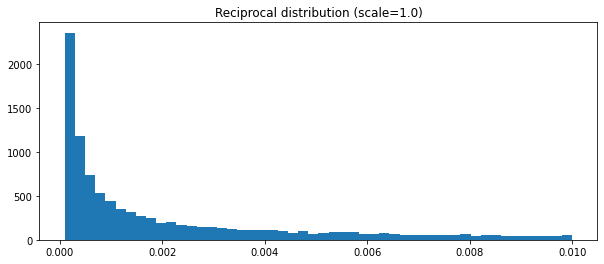

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import reciprocal

# Distribution for 'alpha'
reciprocal_distrib = reciprocal(0.0001, 0.01)
# Generate a random numbers
samples = reciprocal_distrib.rvs(10000, random_state=12)
# Plot
plt.figure(figsize=(10, 4))
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.show()

# Parameter space with RandomizedSearchCV
parameter = {"alpha": reciprocal(0.0001, 0.01), "warm_start": [True, False]}

## Random Sample Consensus

The algorithm splits the complete input sample data into a set of inliers, which may be subject to noise and outliers, which could be caused by erroneous measurements or invalid hypotheses about the data. The resulting model is then estimated **only** from the determined inliers. The `RANSAC` is a non-deterministic algorithm producing only a reasonable result with a certain probability, which is dependent on the number of iterations specified by the `max_trials` parameter. Assuming that the $n$ points needed for estimating a model are selected independently dently, $w^{n}$ is the probability that all n points are inliers and $1-w^{n}$ is the probability that at least one of the n points is an outlier, a case which implies that a bad model will be estimated from this point set. That probability to the power of $k$ is the probability that the algorithm never selects a set of $n$ points which all are inliers and this must be the same as $1-p$. Consequently,
$$
1-p=\left(1-w^{n}\right)^{k}
$$
which, after taking the logarithm of both sides, leads to
$$
k=\frac{\log (1-p)}{\log \left(1-w^{n}\right)}
$$

Each iteration performs the following steps:

1. Select `min_samples` random samples from the original data and check whether the set of data is valid (using `is_data_valid`).

<br>

```python
# This can be any arbitrary function
# For instance, it could check that a certain feature contains all classes
def is_data_valid(X, y):
    assert X.shape[0] == min_samples
    assert y.shape[0] == min_samples
    return False
```
<br>

2. Fit a model to the random subset (`base_estimator.fit`) and check whether the estimated model is valid (using `is_model_valid`).

<br>

```python
# This can be any arbitrary function
    def is_model_valid(estimator, X, y):
        assert estimator == something
```

<br>

3. Classify all data as **inliers** or **outliers** by calculating the residuals to the estimated model (`base_estimator.predict(X) - y`). All data samples with absolute residuals smaller than or equal to the `residual_threshold` are considered as inliers. By default the threshold is chosen as the `MAD` (median absolute deviation) of the target values `y`.

4. Save fitted model as best model if number of inlier samples is maximal. In case the current estimated model has the same number of inliers, it is only considered as the best model if it has better score.

These steps are performed either a maximum number of times (`max_trials`) or until one of the special stop criteria are met (`stop_n_inliers` and `stop_score`). The final model is estimated using all inlier samples (consensus set) of the previously determined best model.



In [ ]:
from sklearn.linear_model import RANSACRegressor
from math import inf

RANSACRegressor(
    estimator=None,
    # Need to set this to a reasonable value
    min_samples=None,
    residual_threshold=None,
    is_data_valid=None,
    is_model_valid=None,
    max_trials=100,
    max_skips=inf,
    stop_n_inliers=inf,
    stop_score=inf,
    stop_probability=0.99,
    loss="absolute_error",
    random_state=None,
)

### Preprocessing

* Requires standardization (subtract mean and divide by standard deviation).

* Need a `is_data_valid` function.

### Hyperparameter Tuning

* min_samples

* max_trials

* loss

In [ ]:
import numpy as np

X = np.zeros((100, 2))
# Number of training samples
n_train = X.shape[0]

parameter = [
    {
        "min_samples": [n_train * 0.25, n_train * 0.5, n_train * 0.75],
        "max_trials": [100, 200, 500],
        "loss": ["absolute_error", "squared_error"],
    }
]

## Tree Based Regressor

### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

DecisionTreeRegressor(
    criterion="squared_error",
    splitter="best",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    # A good value is m = sqrt(p) based on ISL book
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    # Greater values of ccp_alpha increase the number of nodes pruned
    ccp_alpha=0.0,
)

### Preprocessing

* No need to standardize.

* High variance (tend to overfit the training data).

### Hyperparameter Tuning

* min_samples_leaf

* min_samples_split

* max_depth 

* max_features 

In [ ]:
parameter = [
    {
        "max_features": ["sqrt", "log2"],
        "ccp_alpha": [0.0, 0.25, 0.5, 0.75],
        "min_samples_split": [10, 100, 200],
    }
]

### Bagging Regressor

In [ ]:
from sklearn.ensemble import BaggingRegressor

BaggingRegressor(
    # If None, then the base estimator is a DecisionTreeRegressor
    base_estimator=None,
    # Number of base estimators in the ensemble
    n_estimators=10,
    max_samples=1.0,
    max_features=1.0,
    # Bootstrap samples with replacement
    bootstrap=True,
    bootstrap_features=False,
    # Use out-of-bag samples to estimate the generalization error
    oob_score=True,
    warm_start=False,
    random_state=None,
    n_jobs=-1,
    verbose=0,
)

### Preprocessing

* No need to standardize.

* Reduce variance of individual weak learners.

### Voting Regressor

In [ ]:
from sklearn.ensemble import VotingRegressor

VotingRegressor(
    # List of (str, estimator) tuples
    estimators=[("lr", LinearRegression()), ("dt", DecisionTreeRegressor())],
    weights=None,
    n_jobs=-1,
    verbose=False,
)

### Requirement

* Generally taken out towards the end of the project once there are a few strong candidate models. A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction.

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RandomForestRegressor(
    n_estimators=100,
    criterion="squared_error",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    # Set to False by default
    oob_score=True,
    # Change to -1 to use all cores
    n_jobs=-1,
    # Controls bootstrapping of the samples when creating trees and getting a random subsets of features to search for the best feature for splitting
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)

# Roughly equivalent to the following
BaggingRegressor(
    DecisionTreeRegressor(criterion="mse", splitter="random", max_features=1.0),
    n_estimators=100,
    random_state=None,
)

### Preprocessing

* No need to standardize.

* Reduce variance of individual weak learners. Trading higher bias (underfitting) for a lower variance (overfitting).

* Differs from bagging by introducing more randomness and diversity such that each split only considers a subset of the predictors or features, which can be controlled via `max_features`. Instead of searching for the very best feature among all features when splitting a node, it searches for the best feature among a random subset of features.

### Hyperparameter Tuning

* `RandomForestRegressor` has most of the hyperparameters of a `DecisionTreeRegressor` (to control how trees are grown) and all the hyperparameters of a `BaggingRegressor` to control the ensemble itself.

In [ ]:
parameter = [
    {
        "n_estimators": [100, 300, 500],
        "max_features": ["sqrt", "log2"],
        "ccp_alpha": [0.0, 0.25, 0.5, 0.75],
        "min_samples_split": [10, 100, 200],
        "max_samples": [0.5, 0.75, 1.0],
    }
]

### Extra Tree Regressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

ExtraTreesRegressor(
    n_estimators=100,
    criterion="squared_error",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    # Changed default values from False to True
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)

### Preprocessing

* No need to standardize.

* Even more randomness and diversity than `RandomForestClassifier` by using random thresholds for each feature rather than searching for the best possible thresholds at each split.

### Hyperparameter Tuning

In [ ]:
parameter = [
    {
        "n_estimators": [100, 300, 500],
        "max_features": ["sqrt", "log2"],
        "ccp_alpha": [0.0, 0.25, 0.5, 0.75],
        "min_samples_split": [10, 100, 200],
        "max_samples": [0.5, 0.75, 1.0],
    }
]

### AdaBoost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

AdaBoostRegressor(
    # If None, then a DecisionTreeRegressor initialized with max_depth=3
    base_estimator=None,
    # In case of perfect fit, the learning procedure is stopped early
    n_estimators=500,
    # Higher learng rate penalizes weak learners with higher error rates more and rewards stronger learners with lower error rates more
    learning_rate=1.0,
    loss="linear",
    random_state=None,
)

### Preprocessing

* Depending on the base estimator used, inputs may need to be standardized.

### Hyperparameter Tuning

* base_estimator

* n_estimators (controlling underfitting (high bias) or overderfitting (high variance) trade-off)

* learning_rate (how much should worst weak learners be penalized and stronger learners to be rewarded)

* loss (the loss function to use when updating the weights after each boosting iteration)

In [ ]:
from sklearn.svm import SVR, LinearSVR

parameter = [
    {
        "base_estimator": [SVR(kernel="rbf"), LinearSVR()],
        "n_estimators": [500, 1000],
        "loss": ["linear", "square", "exponential"],
        # Values that Friedman (2001) used in his simulation study
        "learning_rate": [1.0, 0.5, 0.25, 0.125, 0.06],
    }
]

# Classification

## Distance Based Classifier

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(
    # Specify the norm of the penalty, since regularization is applied by default
    penalty="l2",
    # Prefer dual=False when n_samples (rows) > n_features (columns), which is usually the case
    dual=False,
    tol=0.0001,
    # Must be a positive float where smaller values specify stronger regularization
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.
    class_weight=None,
    # Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data
    random_state=None,
    # {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’} default=’lbfgs’
    solver="lbfgs",
    max_iter=100,
    multi_class="auto",
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)

### Solver Choice

The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:

* 'newton-cg' - [‘l2’, ‘none’]

* 'lbfgs' - [‘l2’, ‘none’]

* ‘liblinear’ - [‘l1’, ‘l2’]

* ‘sag’ - [‘l2’, ‘none’]

* ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

The ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale.

### Preprocessing

* Requires feature scaling.

### Hyperparameter Tuning

The logistic regression does not really have any critical hyperparameters to tune.

* solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
  
Regularization (penalty) can sometimes be helpful.

* penalty in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]

The C parameter controls the penalty strength, which can also be effective.

* C in [100, 10, 1.0, 0.1, 0.01]



In [ ]:
# 3 x 1 x 4 combinations
parameter = [
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"],
        "penalty": ["l2"],
        "min_samples_split": [100, 10, 1.0, 0.1],
    }
]

## Tree Based Classifier


### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    # Hyperparameter
    max_depth=None,
    # Hyperparameter
    min_samples_split=2,
    # Hyperparameter
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    # A good value is m = sqrt(p) based on ISL book
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    # Hyperparameter
    # Greater values of ccp_alpha increase the number of nodes pruned
    ccp_alpha=0.0,
)

### Preprocessing

* No need to standardize.

* High variance (tend to overfit the training data).

### Hyperparameter Tuning

* min_samples_leaf (Regularizer)

* min_samples_split (Regularizer)

* max_depth (Pruning)

* max_features (Pruning)

In [ ]:
parameter = [
    {
        "max_features": ["sqrt", "log2"],
        "ccp_alpha": [0.0, 0.25, 0.5, 0.75],
        "min_samples_split": [10, 100, 200],
    }
]

### Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

BaggingClassifier(
    # If None, then the base estimator is a DecisionTreeClassifier
    base_estimator=None,
    # Number of base estimators in the ensemble
    n_estimators=10,
    max_samples=1.0,
    max_features=1.0,
    # Bootstrap samples with replacement
    bootstrap=True,
    bootstrap_features=False,
    # Use out-of-bag samples to estimate the generalization error
    oob_score=True,
    warm_start=False,
    random_state=None,
    n_jobs=-1,
    verbose=0,
)

### Preprocessing

* No need to standardize.

* Reduce variance of individual weak learners.

### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

VotingClassifier(
    estimators=[("dt", DecisionTreeClassifier())],
    # Hard or soft voting
    voting="hard",
    weights=None,
    n_jobs=-1,
    # If voting='soft' and flatten_transform=True, transform method returns matrix with shape (n_samples, n_classifiers * n_classes)
    # If flatten_transform=False, it returns (n_classifiers, n_samples, n_classes)
    flatten_transform=True,
    verbose=False,
)

### Requirement

* If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the `argmax` of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers. All classifier must have a `predict_proba` method.

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="sqrt",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    # Set to False by default
    oob_score=True,
    n_jobs=-1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)

# Roughly equivalent to the following
BaggingClassifier(
    DecisionTreeClassifier(criterion="gini", splitter="random", max_features="sqrt"),
    n_estimators=100,
    random_state=None,
)

### Preprocessing

* No need to standardize.

* Reduce variance of individual weak learners. Trading higher bias (underfitting) for a lower variance (overfitting).

* Differs from bagging by introducing more randomness and diversity such that each split only considers a subset of the predictors or features, which can be controlled via `max_features`. Instead of searching for the very best feature among all features when splitting a node, it searches for the best feature among a random subset of features.

### Hyperparameter Tuning

* `RandomForestClassifer` has most of the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown) and all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

In [ ]:
parameter = [
    {
        "n_estimators": [100, 300, 500],
        "max_features": ["sqrt", "log2"],
        "ccp_alpha": [0.0, 0.25, 0.5, 0.75],
        "min_samples_split": [10, 100, 200],
        "max_samples": [0.5, 0.75, 1.0],
    }
]

### Extra Tree Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ExtraTreesClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="sqrt",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    # Changed default values from False to True
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)

### Preprocessing

* No need to standardize.

* Even more randomness and diversity than `RandomForestClassifier` by using random thresholds for each feature rather than searching for the best possible thresholds at each split.

### Hyperparameter Tuning

In [ ]:
parameter = [
    {
        "n_estimators": [100, 300, 500],
        "max_features": ["sqrt", "log2"],
        "ccp_alpha": [0.0, 0.25, 0.5, 0.75],
        "min_samples_split": [10, 100, 200],
        "max_samples": [0.5, 0.75, 1.0],
    }
]

### AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoostClassifier(
    # Base esitmator where sample weighting is required, as well as proper classes_ and n_classes_ attributes
    # If None, then the base estimator is DecisionTreeClassifier initialized with max_depth=1
    base_estimator=None,
    # In case of perfect fit, the learning procedure is stopped early
    n_estimators=500,
    # Higher learng rate penalizes weak learners with higher error rates more and rewards stronger learners with lower error rates more
    learning_rate=1.0,
    # The base_estimator must support calculation of class probabilities with 'SAMME.R', and 'SAMME' uses the SAMME discrete boosting algorithm
    algorithm="SAMME.R",
    random_state=None,
)

### Preprocessing

* Depending on the base estimator used, inputs may need to be standardized.

### Hyperparameter Tuning

* base_estimator

* n_estimators (controlling underfitting (high bias) or overderfitting (high variance) trade-off)

* learning_rate (how much should worst weak learners be penalized and stronger learners to be rewarded)

In [ ]:
from sklearn.svm import SVC, LinearSVC

parameter = [
    {
        "base_estimator": [
            SVC(kernel="rbf"),
            DecisionTreeClassifier(max_depth=3),
            LinearSVC(),
        ],
        "n_estimators": [500, 1000],
        # Values that Friedman (2001) used in his simulation study
        "learning_rate": [[1.0, 0.5, 0.25, 0.125, 0.06]],
    }
]